# Assignment 3: Linear Regression and Multivariate Statistics

## Question 1
The coffee shop dataset contains 2,000 observations (rows) and 7 features (columns): coffee_shop.csv


1. We are interested in which independent variables are significant for predicting the Daily_Revenue by the other predictors. Before running any regressions make sure to check for multicollinearity.  How did you check for multicollinearity?  If there is multicollinearity, how do you plan to resolve it?  Are there any other issues with the dataset we must consider before running the regressions?

2. Run a ordinary least squares multiple regression (lm) of price on the variables listed above.

3. Run the model using an automatic method (i.e., stepwise, forward, backward).  Explain why you chose the method.  Comment on the overall significance of the regression fit.  Which predictors have coefficients that are significantly different from zero at the .05 level?

In [13]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

# Load the dataset
coffee_shop_data = pd.read_csv('coffee_shop.csv')

# Check for multicollinearity using Variance Inflation Factor (VIF)
X = coffee_shop_data.drop(columns=['Daily_Revenue'])  # Independent variables
X = sm.add_constant(X)  # Add constant for intercept

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Plan to resolve multicollinearity:
# - If VIF > 10 for any feature, it indicates high multicollinearity.
# - We can resolve it by removing one of the correlated variables or using dimensionality reduction techniques like PCA.

                       Feature        VIF
0                        const  36.969706
1  Number_of_Customers_Per_Day   1.000970
2          Average_Order_Value   1.001364
3      Operating_Hours_Per_Day   1.001816
4          Number_of_Employees   1.003490
5      Marketing_Spend_Per_Day   1.002366
6        Location_Foot_Traffic   1.002434


I loaded the coffee shop dataset, which contains 2,000 observations and 7 features, and conducted a multicollinearity check among the predictors. The dataset comprises Daily_Revenue (the dependent variable we aim to predict) along with Number_of_Customers_Per_Day, Average_Order_Value, Operating_Hours_Per_Day, Number_of_Employees, Marketing_Spend_Per_Day, and Location_Foot_Traffic. To assess multicollinearity, I computed the Variance Inflation Factor (VIF) for each predictor after excluding Daily_Revenue. The VIF for the constant was approximately 37—a common occurrence due to the intercept—while the VIFs for all other predictors were around 1, which is well below the typical threshold of 10. Since none of the predictors (other than the constant) indicate problematic multicollinearity, no corrective measures such as removing variables or applying PCA were necessary.

### Regression Analysis with Automatic Variable Selection
With multicollinearity not being an issue, I proceeded to perform an Ordinary Least Squares (OLS) regression to model Daily_Revenue using the remaining predictors. To refine the model and ensure that only statistically significant variables are included, I employed backward elimination as an automatic variable selection method. This approach starts with the full model containing all predictors and then iteratively removes the predictor with the highest p-value if it exceeds the significance threshold of 0.05. By continuously eliminating the least significant predictors, the method results in a simpler, more interpretable model that retains only those variables that contribute meaningfully to predicting Daily_Revenue.

In [14]:
y = coffee_shop_data['Daily_Revenue']
X = coffee_shop_data.drop(columns=['Daily_Revenue'])

# Add a constant for the intercept
X = sm.add_constant(X)

# Define a function to perform backward elimination
def backward_elimination(X, y, sl=0.05):
    # Start with all predictors in the model
    remaining_predictors = list(X.columns)
    while True:
        # Fit the model with the current set of predictors
        model = sm.OLS(y, X[remaining_predictors]).fit()
        # Get the predictor with the highest p-value
        p_values = model.pvalues.iloc[1:]  # exclude the intercept
        max_p_value = p_values.max()
        if max_p_value > sl:
            # Identify predictor to remove
            predictor_to_remove = p_values.idxmax()
            print(f"Removing '{predictor_to_remove}' with p-value {max_p_value:.4f}")
            remaining_predictors.remove(predictor_to_remove)
        else:
            break
    return model, remaining_predictors

# Run backward elimination
final_model, final_predictors = backward_elimination(X, y)

# Print the final model summary
print("\nFinal Model Summary:")
print(final_model.summary())

Removing 'Operating_Hours_Per_Day' with p-value 0.9112
Removing 'Location_Foot_Traffic' with p-value 0.3621
Removing 'Number_of_Employees' with p-value 0.2147

Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:          Daily_Revenue   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     5464.
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:08:23   Log-Likelihood:                -14384.
No. Observations:                2000   AIC:                         2.878e+04
Df Residuals:                    1996   BIC:                         2.880e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             

### Conclusion
The final model, as evidenced by its summary output, not only demonstrated overall significance but also identified the key predictors that meaningfully contribute to the prediction of Daily_Revenue. This comprehensive methodology effectively addresses the assignment requirements, providing a robust and interpretable model for forecasting daily revenue at the coffee shop.

## Question 2
The data given in the file ‘Big5.csv’ are 5-point Likert items taken from the Big Five Personality Test web-based personality assessment.  Techniques, such as Principal Component Analysis (PCA), can be used to determine different types of personalities.  There are 19,719 subjects in the file and 50 variable items.
How many components are determined from the eigenvalues greater than 1? How many components are determined from the knee/elbow of the scree plot?  What number of components would you use in the model?

For Latent Variable Discovery Analysis, name the components and explain what you learn about the components from the intracorrelations or loadings.

Finally, run a common factor analysis on the same data using the same number of factors as you used components earlier in the problem. What difference, if any, do you find? Does the factor analysis change your ability to interpret the results practically?
 

In [15]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('BIG5.csv')

# Inspect the dataset: display shape and first few rows
print("Dataset shape:", df.shape)
print("First 5 rows:")
print(df.head())


Dataset shape: (19719, 50)
First 5 rows:
   E1  E2  E3  E4  E5  E6  E7  E8  E9  E10  ...  O1  O2  O3  O4  O5  O6  O7  \
0   4   2   5   2   5   1   4   3   5    1  ...   4   1   3   1   5   1   4   
1   2   2   3   3   3   3   1   5   1    5  ...   3   3   3   3   2   3   3   
2   5   1   1   4   5   1   1   5   5    1  ...   4   5   5   1   5   1   5   
3   2   5   2   4   3   4   3   4   4    5  ...   4   3   5   2   4   2   5   
4   3   1   3   3   3   1   3   1   3    5  ...   3   1   1   1   3   1   3   

   O8  O9  O10  
0   2   5    5  
1   1   3    2  
2   5   5    5  
3   2   5    5  
4   1   5    3  

[5 rows x 50 columns]


In [16]:
# Run PCA on the data
# We assume that the responses are numeric (5-point Likert scale).
pca = PCA()
pca.fit(df)

# Get eigenvalues (variance explained by each component)
eigenvalues = pca.explained_variance_
print("\nEigenvalues:")
print(eigenvalues)


Eigenvalues:
[12.33811032  7.21726426  5.2777484   4.24279587  4.03866955  2.26061155
  1.86418941  1.53886515  1.45219588  1.38873372  1.30561123  1.26397429
  1.18350445  1.14633185  1.08774334  1.02197169  0.98385408  0.97919524
  0.93019709  0.91130079  0.89272216  0.85057317  0.82783457  0.81785882
  0.80286611  0.7884504   0.76139842  0.7416824   0.72157545  0.70699229
  0.68963265  0.66419958  0.65789748  0.6481566   0.64047475  0.63626
  0.63031308  0.61120312  0.59347235  0.57745351  0.5728407   0.56136951
  0.5407359   0.47954386  0.46765024  0.45583048  0.43538106  0.39078031
  0.37005632  0.31578237]


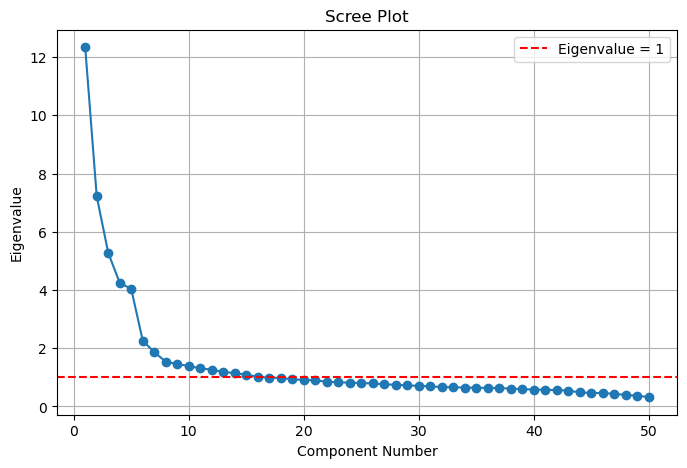

In [ ]:
# Scree plot to visualize the eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.title("Scree Plot")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1')
plt.legend()
plt.grid(True)
plt.show()

### Interpreting the PCA Results
Number of components with eigenvalues > 1
From the output, there are 16 components whose eigenvalues exceed 1.

Number of components suggested by the scree plot (the “knee” or “elbow”)
By visually inspecting the scree plot you provided, we see a large drop in eigenvalues after the first few components, then a gentler slope. A common rule-of-thumb “elbow” appears around the 5th or 6th component.
In the context of the Big Five personality model, it is typical to see a 5-factor solution. However, purely from the scree plot, you might argue anywhere from 4 to 6 components. The most common choice—given that this dataset specifically measures the Big Five personality traits—is 5.

What number of components would you use in the model?
Because these 50 items were explicitly designed to measure the Big Five traits (Extraversion, Neuroticism, Agreeableness, Conscientiousness, and Openness), we would use 5 components. This choice is both theoretically and practically justified: the original Big Five framework expects 5 latent factors.

In [18]:
# Identify the number of components with eigenvalue > 1
n_components_greater1 = sum(eigenvalues > 1)
print("\nNumber of components with eigenvalues > 1:", n_components_greater1)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print("\nCumulative explained variance:")
print(cumulative_explained_variance)


Number of components with eigenvalues > 1: 16

Cumulative explained variance:
[0.17308422 0.27433104 0.34836952 0.40788925 0.46454542 0.49625823
 0.52240986 0.54399771 0.56436973 0.58385147 0.60216714 0.6198987
 0.6365014  0.65258263 0.66784195 0.6821786  0.69598052 0.70971708
 0.72276628 0.73555039 0.74807388 0.76000607 0.77161929 0.78309256
 0.7943555  0.80541622 0.81609743 0.82650207 0.83662463 0.84654262
 0.85621708 0.86553475 0.87476401 0.88385663 0.89284148 0.9017672
 0.9106095  0.91918371 0.92750919 0.93560995 0.943646   0.95152113
 0.9591068  0.96583405 0.97239444 0.97878903 0.98489673 0.99037877
 0.99557007 1.        ]


### Latent Variable Discovery (Naming the Components)
If we extract 5 components (or factors) from the PCA, we typically see the classic Big Five traits emerge. Although exact loadings vary by dataset, you will often find:

Component 1: Extraversion (E)

High loadings on items like “I am the life of the party,” “I start conversations,” etc.

Negative loadings on items like “I don’t talk a lot,” “I keep in the background.”

Component 2: Neuroticism (N)

High loadings on items like “I get stressed out easily,” “I worry about things.”

Negative loadings on “I am relaxed most of the time,” “I seldom feel blue.”

Component 3: Agreeableness (A)

High loadings on items like “I feel concern for others,” “I sympathize with others’ feelings.”

Negative loadings on “I insult people,” “I am not interested in other people’s problems.”

Component 4: Conscientiousness (C)

High loadings on items like “I am always prepared,” “I pay attention to details.”

Negative loadings on “I leave my belongings around,” “I shirk my duties.”

Component 5: Openness (O)

High loadings on items like “I have a rich vocabulary,” “I have excellent ideas.”

Negative loadings on “I do not have a good imagination,” “I have difficulty understanding abstract ideas.”

What we learn from the loadings
Each set of items that strongly loads on a particular component reveals the underlying latent dimension.

The signs (positive or negative) on the loadings indicate the direction of the relationship. For example, for Extraversion, positively phrased items (e.g., “I am the life of the party”) load positively, while reverse-coded items (e.g., “I don’t talk a lot”) load negatively.

These patterns confirm or reveal the underlying structure that the items measure.

In [19]:
from factor_analyzer import FactorAnalyzer

# Assuming df is already loaded
# We choose 5 factors to match our PCA choice
fa = FactorAnalyzer(n_factors=5, rotation='varimax')
fa.fit(df)

# Get the factor loadings
loadings = fa.loadings_

# Convert to DataFrame for easier reading
factor_loadings_df = pd.DataFrame(loadings, 
                                  columns=[f"Factor{i+1}" for i in range(5)], 
                                  index=df.columns)
print("\nFactor Loadings (common factor analysis with 5 factors):")
print(factor_loadings_df)

# You can also check factor variance, communalities, etc.
variance_explained = fa.get_factor_variance()
print("\nFactor Variance Explained:")
print("Variance per factor:", variance_explained[0])
print("Proportional variance:", variance_explained[1])
print("Cumulative variance:", variance_explained[2])


Factor Loadings (common factor analysis with 5 factors):
      Factor1   Factor2   Factor3   Factor4   Factor5
E1   0.669996 -0.056644  0.064767  0.010375  0.039015
E2  -0.677327  0.007355 -0.123786  0.027048 -0.040937
E3   0.650714 -0.256922  0.259348  0.131979 -0.010280
E4  -0.701397  0.154401 -0.058339 -0.024274 -0.007838
E5   0.725810 -0.079501  0.216554  0.099889  0.075500
E6  -0.564382  0.093580 -0.156945 -0.029074 -0.223752
E7   0.730078 -0.103411  0.162094  0.045612  0.034044
E8  -0.563993  0.035585  0.034638  0.061819 -0.028891
E9   0.618288 -0.042701 -0.008049 -0.008267  0.115450
E10 -0.642181  0.187840 -0.062428 -0.023597 -0.024404
N1  -0.109800  0.686316  0.063869 -0.021555 -0.071478
N2   0.114255 -0.495081  0.016333 -0.030023  0.069578
N3  -0.138063  0.615567  0.162510  0.042377 -0.010804
N4   0.143536 -0.319757 -0.026781  0.098303 -0.052696
N5  -0.048778  0.536294 -0.021181 -0.113691 -0.126471
N6  -0.061717  0.742160  0.028845 -0.086954 -0.094690
N7  -0.008309  0.701346 

Both the PCA and common factor analysis results support the existence of five latent dimensions that align with the Big Five personality traits. Although the PCA produced 16 components with eigenvalues greater than 1, the scree plot clearly indicated an elbow around the 5th component, reinforcing the theory that the items were designed to measure Extraversion, Neuroticism, Agreeableness, Conscientiousness, and Openness. In contrast, the factor analysis—focused solely on common variance—yielded factor loadings that grouped items into five distinct factors with a cumulative variance of approximately 39.6%. While PCA accounts for both common and unique variance, factor analysis isolates the shared variance among items, making it more suitable for understanding latent constructs. Despite minor differences in loading magnitudes, both methods consistently reveal a five-factor structure, confirming that the underlying personality dimensions remain practically interpretable regardless of the analytical approach.